In [1]:
# Load the necessary libraries
import pandas as pd
#data comes from: 
#http://service.iris.edu/fdsnws/dataselect/1/query?net=CU&sta=GRTK&loc=00&cha=BHZ&starttime=2024-09-06T00:00:00&endtime=2024-09-06T00:01:00&format=csv

from obspy import read
from io import BytesIO
import requests
from datetime import datetime, timedelta
import numpy as np

#import configuration location and filepath
from myconfig import *


# Initialize date_now and date_proc
date_now = datetime.utcnow()  # Using UTC
date_start = date_now - timedelta(minutes=1)

# Convert to string formats for URL
date_str1 = date_start.strftime("%Y-%m-%dT%H:%M:%S")
date_str2 = date_now.strftime("%Y-%m-%dT%H:%M:%S")

# Define initial URL with formatted date range
url_template = 'http://service.iris.edu/fdsnws/dataselect/1/query?net=CU&sta=GRTK&loc=00&cha=BHZ&starttime={}&endtime={}&format=miniseed'
success = False

# Increment endtime until a successful response
while not success:
    url = url_template.format(date_str1, date_str2)
    response = requests.get(url)
    
    if response.status_code == 204:
        print("No content available. Incrementing endtime by 1 minute...")
        date_start -= timedelta(minutes=1)
        date_str1 = date_start.strftime("%Y-%m-%dT%H:%M:%S")
    else:
        try:
            response.raise_for_status()  # Raises an error if other non-2xx status codes are encountered
            success = True  # Exit the loop if successful
            print("Data successfully retrieved.")
        except requests.exceptions.HTTPError as e:
            print(f"Request failed: {e}. Retrying with an incremented endtime...")
            date_now += timedelta(minutes=1)
            date_str2 = date_now.strftime("%Y-%m-%dT%H:%M:%S")
            

print(f"Successful URL: {url}")

# Read the MiniSEED data into an ObsPy Stream object
stream = read(BytesIO(response.content))

# Convert the Stream into a Trace object (there may be multiple Traces in a Stream)
trace = stream[0]

# Create a DataFrame from the Trace data
# Extract the time vector and the waveform data (trace data)
time = trace.times("timestamp")  # get timestamps
data = trace.data  # get the waveform data

# Create the DataFrame
df = pd.DataFrame({'Time': time, 'Sample': data})

# Display the first few rows of the DataFrame
#print(df.head())

/tmp/ipykernel_29674/1193474459.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date_now = datetime.utcnow()  # Using UTC


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


No content available. Incrementing endtime by 1 minute...


Data successfully retrieved.
Successful URL: http://service.iris.edu/fdsnws/dataselect/1/query?net=CU&sta=GRTK&loc=00&cha=BHZ&starttime=2024-10-25T23:53:36&endtime=2024-10-26T00:01:36&format=miniseed


In [2]:

# Load the CSV file into a DataFrame
#file_path = '../data/CU.GRTK.00.BHZ.M.2024-09-06T000000.019539.csv'
#df = pd.read_csv(file_path, comment='#')

#Time, Sample 2024-09-06T00:00:00.019539Z, 7046

# Convert DATE and TIME to a single datetime column and round up to the next hour
#date = datetime.fromtimestamp(timestamp)
df['DATETIME'] = df['Time'].apply(lambda ts: datetime.fromtimestamp(ts)) #datetime.fromtimestamp(df['Time'])
#df['DATETIME'] = df['DATETIME'].dt.ceil('h')  # Round to the next hour

# Set DATETIME as the index
df.set_index('DATETIME', inplace=True)

#df_data = df[[' Sample']]
df_data = df[['Sample']]


In [3]:
#df_data.head()

In [4]:
rows = len(df_data)
#print(rows)

In [5]:
#df_data.shape

In [6]:


# Assuming df_data has 9600 rows
rows = len(df_data)  # Total number of rows in the DataFrame (9600)
target_rows = 1800  # Desired number of rows after downsampling

# Calculate the number of rows per group (group size)
group_size = rows / target_rows  # This results in 5.3333...

# Create groups dynamically using np.floor(np.arange())
df_data['group'] = np.floor(np.arange(rows) / group_size).astype(int)

# Now downsample by taking the mean (or max) of each group
downsampled_df = df_data.groupby('group').max()  # Or use .max(), depending on your requirement

# Drop the 'group' column if necessary
# downsampled_df.drop(columns='group', inplace=True)

# Display the first few rows of the downsampled DataFrame
#downsampled_df.head()


In [7]:
#downsampled_df.shape

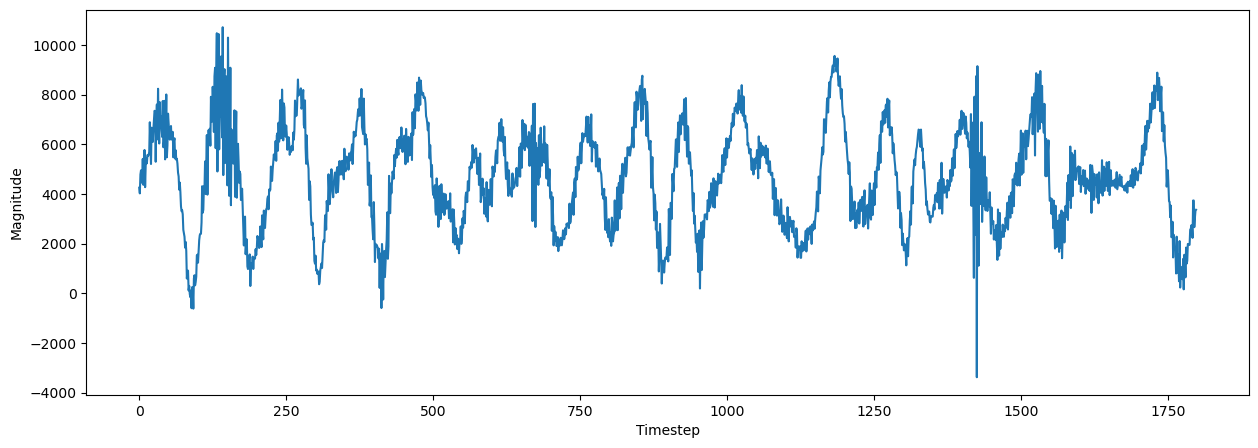

In [8]:
#graph
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(downsampled_df.index,downsampled_df["Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig(output_path_figures+"seismic_realtime.png")

In [9]:
downsampled_df.to_csv(output_path_seismic+"seismic_1800.csv", index = True)

In [10]:
#normalize and park at 3600


# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
normalized_sample = (downsampled_df['Sample'] - downsampled_df['Sample'].min()) / (downsampled_df['Sample'].max() - downsampled_df['Sample'].min())

# Create a new DataFrame with an index from 0 to 7199
new_df = pd.DataFrame(index=np.arange(7200))

# Fill the new DataFrame with 0.0 values initially
new_df['Sample'] = 0.0

# Find the start index to center the data at index 3599
start_idx = 3599

# Place the normalized data in the new DataFrame starting at 'start_idx'
new_df.loc[start_idx:start_idx + len(normalized_sample) - 1, 'Sample'] = normalized_sample.values

# Display the resulting DataFrame
#new_df.head(10), new_df.tail(10)


In [11]:
#new_df.dtypes

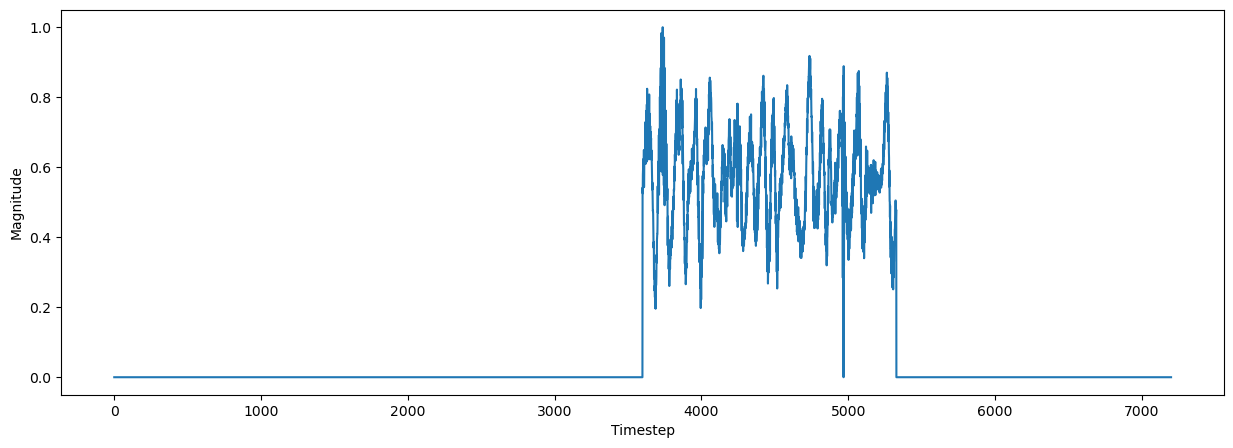

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(new_df.index,new_df["Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig(output_path_figures+"seismic_realtime_7200.png")

In [13]:
fout = output_path_nrt + 'seismic_7200.csv'
new_df.to_csv(fout, index = True)